# 3. The BlueiceExtendedModel: Sensitivity Studies
In this tutorial, we'll learn how to use the `Runner` class to perform sensitivity studies. As an example we'll again use the `BlueiceExtendedModel` and perform a sensitivity study for a Dark Matter search experiment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from alea import Runner
from alea.utils import load_yaml
from inference_interface import toyfiles_to_numpy

In [2]:
# Just some plotting settings
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9
mpl.rcParams["mathtext.fontset"] = "dejavuserif"

The sensitivity of a direct WIMP detection experiment is commonly expressed in terms of the median of upper limits that one would be able to set on the WIMP-nucleon cross-section in case of a background-only dataset. Thus we would:
* Generate background-only toy data (i.e. `wimp_rate_multiplier = 0`)
* Construct the confidence interval on the WIMP-nucleon cross-section as we did in the previous tutorial
* Repeat this procedure many times and store the upper limits
* Take the median of the upper limits as the sensitivity

By now you should be able to do this by hand but you will learn in the following how to do this in a more efficient way using the `Runner` class of alea.

Since we will use the same simple WIMP model with ER background as before, we'll start by loading the config file of the model:

In [3]:
file_path = "unbinned_wimp_statistical_model_simple.yaml"
model_config = load_yaml(file_path)

Then we can initialize the runner. Specifying `generate_values={'wimp_rate_multiplier': 0.0}` means that despite the default value of 1.0 in the model configuration file, it will always be set to zero in the data generation, which means we'll generate data without signal.

We'll then parse the model configuration (`model_config`) to define the statistical model as before. We'll start with 100 toy experiments (`n_mc=100`), which may take about one minute to compute. But depending on your machine or patience, you can increase this number to get more precise results.

Other parsed arguments are:
- `statistical_model`: the statistical model to use. Here we want to use the `BlueiceExtendedModel` so we need to specify the path to the module containing the class.
- `poi`: the parameter of interest. Here we want to use the `wimp_rate_multiplier` parameter since we want to test our sensitivity to the signal strength.
- `hypotheses`: This is a list of hypotheses. Each hypothesis is a dictionary with the parameters to fix in the fit and the corresponding fixed value. Some important hypotheses are named: `"free"` means that all parameters are free in the fit (equivalent to `{}`). Other named hypotheses are `"zero"`, which sets the `poi` to zero and `"true"`, which sets it to the value specified in the `generate_values`.
- `compute_confidence_interval`: Boolean to enable the computation of the confidence interval. Of course we have to set it to `True` if we want to compute the sensitivity.
- `toydata_mode`: You could choose between `'read'` (read toy data from file), `'generate'` (generate toys but don't store them), `'generate_and_store'` (generate toy data and store them), `'no_toydata'` (no toy data generated). Note that this doesn't affect whether the results of the runner are stored -- this is always done.

In [4]:
runner = Runner(
    statistical_model="alea.models.blueice_extended_model.BlueiceExtendedModel",
    poi="wimp_rate_multiplier",
    hypotheses=["free"],
    n_mc=100,
    generate_values={"wimp_rate_multiplier": 0.0},
    compute_confidence_interval=True,
    toydata_mode="generate",
    output_filename="out.h5",
    **model_config
)

Computing/loading models on one core: 100%|██████████| 5/5 [00:00<00:00, 412.91it/s]


Let's run the toy experiments...

In [5]:
results = runner.run()

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

Saving out.h5


... and load the results from the output file. Apart from the upper limits, the best-fit results for an unconstrained fit (`hypothesis=['free']`) are stored.

In [6]:
results = toyfiles_to_numpy("out.h5")
uls = results["free"]["ul"]

Now we can look at the distribution of upper limits:

Text(0, 0.5, 'Number of toy experiments')

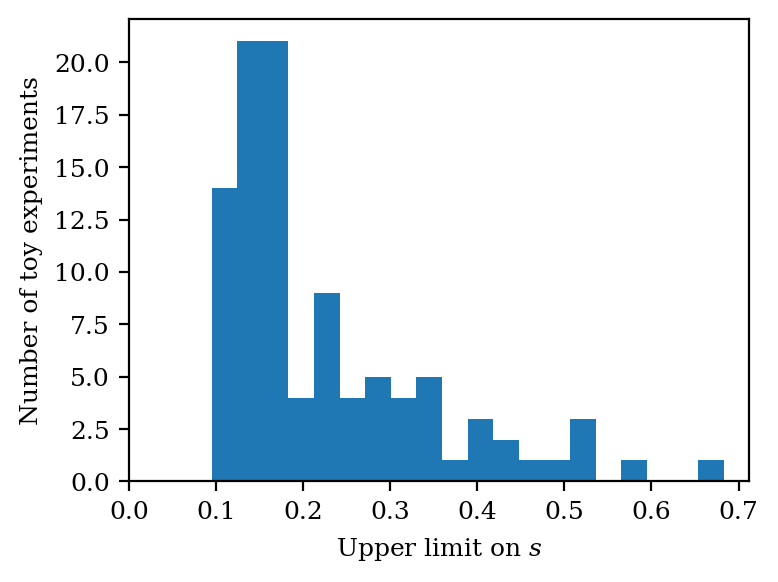

In [7]:
plt.hist(uls, bins=20)

plt.xlim(0)
plt.xlabel("Upper limit on $s$")
plt.ylabel("Number of toy experiments")

Let's convert the upper limits on the `wimp_rate_multiplier` $s$ into values of WIMP-nucleon cross section and visualize the distribution as a cumulative distribution function (CDF). We then compute the median of the upper limits (CDF = 0.5) and the one- and two-sigma bands, which are usually used to quote the sensitivity of an experiment ("Brazilian-flag plot"):

Text(0, 0.5, 'Fraction of ULs below $\\sigma$')

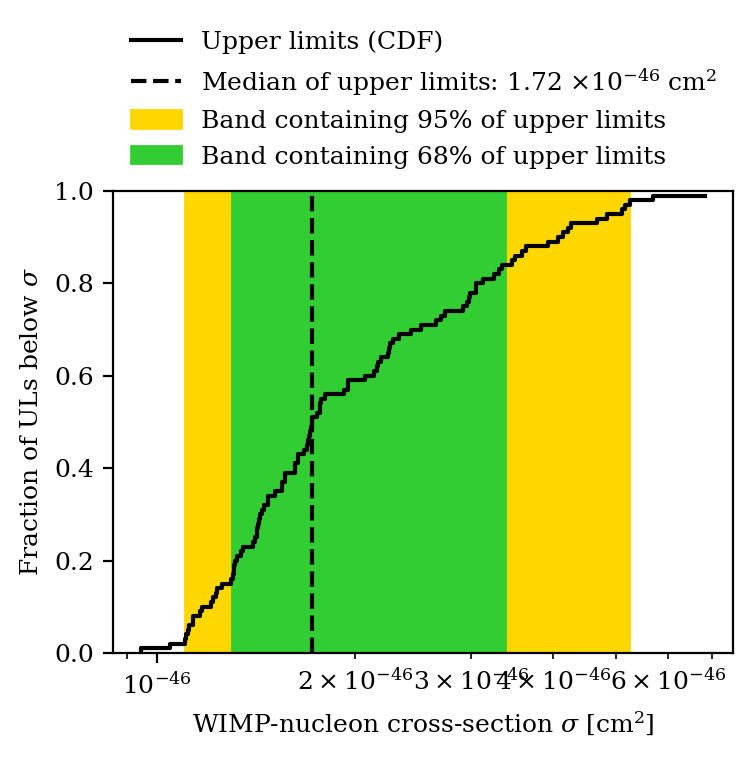

In [8]:
ref_xsec = 1e-45  # cm^2
uls_xsec = uls * ref_xsec
median_ul = np.quantile(uls_xsec, stats.norm().sf(0))

# plot CDF of upper limits
plt.step(
    np.sort(uls_xsec),
    np.linspace(0, 1, len(uls_xsec), endpoint=False),
    color="k",
    label="Upper limits (CDF)",
)

# plot median and bands
plt.axvline(
    median_ul,
    color="k",
    zorder=0,
    ls="--",
    label=rf"Median of upper limits: {median_ul*1e46:.2f} $\times 10^{{-46}}\;\mathrm{{cm}}^2$",
)
plt.axvspan(
    np.quantile(uls_xsec, stats.norm().sf(-2)),
    np.quantile(uls_xsec, stats.norm().sf(2)),
    color="gold",
    zorder=-2,
    label="Band containing 95% of upper limits",
)
plt.axvspan(
    np.quantile(uls_xsec, stats.norm().sf(-1)),
    np.quantile(uls_xsec, stats.norm().sf(1)),
    color="limegreen",
    zorder=-1,
    label="Band containing 68% of upper limits",
)

# Cosmetics
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", frameon=False)
plt.ylim(0, 1)
plt.semilogx()
plt.xlabel("WIMP-nucleon cross-section $\sigma$ [cm$^2$]")
plt.ylabel("Fraction of ULs below $\sigma$")